# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/3325/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t

%matplotlib inline

In [219]:
# Load the nessesary data.
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')

del df['Unnamed: 0'] # delete the 'Unnamed: 0' column
del df_content['Unnamed: 0'] # delete the 'Unnamed: 0' column

# Show the first five rows of the data.
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [220]:
# Show the first five rows of the data.
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [221]:
df.isnull().sum() # so there's 'null' values in the 'email' column

article_id     0
title          0
email         17
dtype: int64

In [222]:
df_content.isnull().sum() # there are 'null' values in the 'doc_body' and 'doc_description' columns

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

In [223]:
# so each 'email' is a user???
# Count 'user interaction', this is the number of 'unique' (hashed) email address
user_interaction = df.email.value_counts(dropna=False)
user_interaction.head()

email
2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
Name: count, dtype: int64

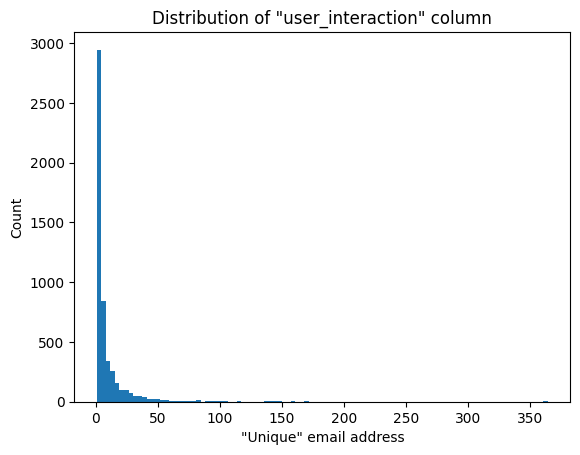

In [224]:
plt.figure()
plt.hist(user_interaction.values, bins=100)
plt.title('Distribution of "user_interaction" column')
plt.xlabel('"Unique" email address')
plt.ylabel('Count')
plt.show()

In [225]:
unique_article_count = df.article_id.value_counts(dropna=False)
something1 = np.cumsum(unique_article_count.values) # 'cumulative sum' 1,2,3 >> 1,3,6

# 50% of individuals interact with ____ number of articles or fewer.
median_val = len(something1[something1 <= len(user_interaction)/2])

# The maximum number of user-article interactions by any 1 user is ______.
max_views_by_user = user_interaction.iloc[0] # 364

print(f'50% of individuals interact with {median_val} number of articles or fewer')
print(f'The maximum number of "user-article interactions(connection)" by any 1 user is {max_views_by_user}')

50% of individuals interact with 3 number of articles or fewer
The maximum number of "user-article interactions(connection)" by any 1 user is 364


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [226]:
# Find and explore duplicate articles
article_count = df_content.article_id.value_counts(dropna=False)
print(article_count[article_count > 1])
dup_articles = article_count[article_count > 1]
# dup_articles

print(f'...................................')
print('number of duplicate articles is: ', len(dup_articles))

article_id
221    2
232    2
50     2
398    2
577    2
Name: count, dtype: int64
...................................
number of duplicate articles is:  5


In [227]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], inplace=True)

# df_content.shape, df_content_no_dup.shape # ((1056, 5), (1051, 5))

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [228]:
# The number of unique articles that have at least one interaction
unique_articles = len(unique_article_count)

# The number of unique articles on the IBM platform
total_articles = df_content.shape[0] # 1051

# The number of unique users
unique_email = df.email.nunique() # 5148

# The number of user-article interactions
user_article_interactions = len(df) # 'article_id' and 'email' 'connections'


print('unique_articles: ', unique_articles)
print('total_articles: ', total_articles)
print('unique_email: ', unique_email)
print('user_article_interactions: ', user_article_interactions)

unique_articles:  714
total_articles:  1051
unique_email:  5148
user_article_interactions:  45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [229]:
# The 'most viewed' article in the dataset as a string with one value following the decimal 
unique_article_id = str(unique_article_count.index[0]) # 1429.0, the 'index' of the first row on the 'series'

# The most viewed article in the dataset was viewed how many times?
# 937, so there is '937' of 1430 in column 'article_id' 
max_views = unique_article_count.iloc[0] # 937, this is the 'first row'

unique_article_count

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1344.0      1
984.0       1
1113.0      1
675.0       1
662.0       1
Name: count, Length: 714, dtype: int64

In [230]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to 'map' the 'user email' to a 'user_id' column and remove the email column

def email_mapper():
    coded_dict = dict()
    counter1 = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = counter1
            counter1 += 1
        
        email_encoded.append(coded_dict[val])

    return email_encoded


# making a new column for user_id
email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header >>> new column 'user_id' is added
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [231]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': unique_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_email,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [232]:
def get_top_articles(n, df = df):

    '''
        INPUT:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df as defined at the top of the notebook 
        
        OUTPUT:
        top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here

    ## Getting the 'article id'
    # 'group by' is like you're making a 'LINK' between the two columns
    # unstack() is the 'make a table'
    user_by_article = df.groupby(['user_id', 'article_id'])['title'].count().unstack()

    # sum() default 'axis' is 'along the column'
    articles_interaction = user_by_article.sum().sort_values(ascending=False) # big value first
    articles_index = articles_interaction.iloc[0:n].index # 1429.0, 1330.0, 1431.0 these are the 'index/location'

    ## Get aritcle's title
    # 2 operations:
    # 1. drop duplicate in column'article_id'
    # 2. get 'stuff' in column 'article_id' and 'title'
    df_art_title = df.drop_duplicates(subset=['article_id'])[['article_id', 'title']]
    df_art_title.index = df_art_title.article_id

    # get list of the top n article titles
    top_articles = list(df_art_title.loc[articles_index].title)
    
    return top_articles # Return the top article titles from df (not df_content)


def get_top_article_ids(n, df = df):

    '''
        INPUT:
        n - (int) the number of top articles to return
        df - (pandas dataframe) df as defined at the top of the notebook 
        
        OUTPUT:
        top_articles - (list) A list of the top 'n' article titles 
    
    '''

    # Your code here
    user_by_article = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    articles_interaction = user_by_article.sum().sort_values(ascending=False)
    top_articles = list(articles_interaction.iloc[:n].index)

    return top_articles  # Return the top article ids

In [233]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [234]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [235]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):

    '''
        INPUT:
        df - pandas dataframe with article_id, title, user_id columns
        
        OUTPUT:
        user_item - user item matrix 
        
        Description:
        Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
        an article and a 0 otherwise
    '''
    # Fill in the function here
    # 'lambday' (no name function)
    # unstack is to 'make a table'
    user_item = df.groupby(['user_id', 'article_id'])['title'].agg(lambda x: 1).unstack()
    asdf2 = user_item.fillna(0, inplace=False)
    
    return asdf2 # return the user_item matrix 


user_item = create_user_item_matrix(df)

In [236]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [237]:
# default value 'user_item' is a DATAFRAME
def find_similar_users(user_id, user_item=user_item):
    
    '''
        INPUT:
        user_id - (int) a user_id
        user_item - (pandas dataframe) matrix of users by articles: 
                    1's when a user has interacted with an article, 0 otherwise
        
        OUTPUT:
        similar_users - (list) an ordered list where the closest users (largest dot product users)
                        are listed first
        
        Description:
        Computes the similarity of every pair of users based on the dot product
        Returns an ordered
    
    '''

# reshape(-1, 1): This part of the code is reshaping the NumPy array into a 2D array (a matrix) 
# with one column and an unknown number of rows (indicated by -1). 
# The -1 tells NumPy to calculate the number of rows automatically based on the original array's length.


    # Compute dotproduct1 of each user to the provided user

    '''
        User 1: [1, 0, 1, 0]
        User 2: [1, 1, 0, 0]

        Dot product: (1*1) + (0*1) + (1*0) + (0*0) = 1

        dot product is 1, meaning that User 1 and User 2 have interacted with one common article. 
        Higher dot product values indicate that users have interacted with more of the same articles
    '''

    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    mat1 = user_item.drop(user_id)
    dotproduct1 = np.dot(mat1.values, user_vector)    

    # sort by dotproduct1
    df_similar = pd.DataFrame({'user_id': mat1.index,
                            'dotproduct1': dotproduct1.flatten()})
    
    df_similar.sort_values(by=['dotproduct1'], inplace=True, ascending=False)

    # Create list of just the ids
    most_similar_users = list(df_similar.user_id)   
       
    return most_similar_users # return a list of the users in order from most to least similar
        

asdf = find_similar_users(1, user_item)
asdf[0:10]

[3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]

In [238]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 46, 4201, 395]
The 5 most similar users to user 3933 are: [1, 23, 3782, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [239]:
# default value 'df' DATAFRAME
def get_article_names(id1, df=df):

    '''
        INPUT:
        id1 - (list) a list of article ids
        df - (pandas dataframe) df as defined at the top of the notebook
        
        OUTPUT:
        article_names - (list) a list of article names associated with the list of article ids 
                        (this is identified by the title column)

                        
        you take in a 'collection' of 'id' and you output the NAMES of the articles
        thank you very much for this simple explanation
    '''

    # Your code here
    # [do_something for asdf in article_ids]
    id1 = [float(asdf) for asdf in id1]

    df_2 = df.drop_duplicates(subset=['article_id'])
    df_2.set_index('article_id', inplace=True)

    article_names = list(df_2.loc[id1]['title'])
    
    return article_names # Return the article names associated with list of article ids


# default value, user_item is a DATAFRAME
def get_user_articles(user_id, user_item=user_item):

    '''
        INPUT:
        user_id - (int) a user id
        user_item - (pandas dataframe) matrix of users by articles: 
                    1's when a user has interacted with an article, 0 otherwise
        
        OUTPUT:
        article_ids - (list) a list of the article ids seen by the user
        article_names - (list) a list of article names associated with the list of article ids 
                        (this is identified by the doc_full_name column in df_content)
        
        Description:
        Provides a list of the article_ids and article titles that have been seen by a user
    '''

    # Your code here
    row_user = user_item.loc[user_id] # the row that the 'user' is in
    article_ids = list(row_user[row_user > 0].index)
    article_ids = [str(x) for x in article_ids]
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


# default value 'user_item' is a DATAFRAME
# default value for recommedation for article is 10
def user_user_recs(user_id, m=10):

    '''
        INPUT:
        user_id - (int) a user id
        m - (int) the number of recommendations you want for the user
        
        OUTPUT:
        recs - (list) a list of recommendations for the user
        
        Description:
        Loops through the users based on closeness to the input user_id
        For each user - finds articles the user hasn't seen before and provides them as recs
        Does this until m recommendations are found
        
        Notes:
        Users who are the same closeness are chosen arbitrarily as the 'next' user
        
        For the user where the number of recommended articles starts below m 
        and ends exceeding m, the last items are chosen arbitrarily
        
    '''

    # Your code here

    # Get user articles
    article_ids, _ = get_user_articles(user_id)

    # Find similar users, the DOT PRODUCT thing
    most_similar_users = find_similar_users(user_id)

    # How many users for progress bar
    n_users = len(most_similar_users)   
    recs = []


    # Loop through similar users
    for user in most_similar_users:       

        # Get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break

    recs = recs[:10]


    return recs # return your recommendations for this user_id    

In [240]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['recommender systems: approaches & algorithms',
 '1448    i ranked every intro to data science course on...\r\nName: title, dtype: object',
 'data tidying in data science experience',
 'a tensorflow regression model to predict house values',
 '520    using notebooks with pixiedust for fast, flexi...\r\nName: title, dtype: object',
 'airbnb data for analytics: mallorca reviews',
 'airbnb data for analytics: vancouver listings',
 'analyze facebook data using ibm watson and watson studio',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings']

In [241]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [242]:
# default value, user_item is a DATAFRAME
# default value, user_id is a DATAFRAME
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
        INPUT:
        user_id - (int)
        df - (pandas dataframe) df as defined at the top of the notebookmat1
        user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise
    
        OUTPUT:
        neighbors_df - (pandas dataframe) a dataframe with:
                        neighbor_id - is a neighbor user_id
                        dotproduct1 - measure of the dotproduct1 of each
                                     user to the provided user_id
                        num_interactions - the number of articles viewed
                                           by the user - if a u
    
        Other Details - sort the neighbors_df by the dotproduct1 and then by number
                   of interactions where highest of each is higher in the dataframe

    '''

    # dotproduct1
    user_vector = np.array(user_item.loc[user_id]).reshape(-1, 1)
    mat1 = user_item.drop(user_id)
    
    dotproduct1 = np.dot(mat1.values, user_vector)
    # sort by dotproduct1
    similar_df = pd.DataFrame({'neighbor_id': mat1.index,
                            'similarity': dotproduct1.flatten()})

    # Number of 'interaction' (connection)
    interaction1 = df.groupby('user_id')['article_id'].count()

    interact_df = pd.DataFrame({'neighbor_id': interaction1.index,
                             'num_interactions': interaction1.values})

    # Merging the two dataframes
    neighbors_df = similar_df.merge(interact_df)

    # sort the neighbors_df
    neighbors_df.sort_values(by=['similarity', 'num_interactions'],
                             inplace=True, ascending=False)

    return neighbors_df


def user_user_recs_part2(user_id, m=10):
    '''
        INPUT:
        user_id - (int) a user id
        m - (int) the number of recommendations you want for the user

        OUTPUT:
        recs - (list) a list of recommendations for the user by article id
        rec_names - (list) a list of recommendations for the user by article title

        Description:
        Loops through the users based on closeness to the input user_id
        For each user - finds articles the user hasn't seen before and
                        provides them as recs
        Does this until m recommendations are found

        Notes:
        * Choose the users that have the most total article interactions
        before choosing those with fewer article interactions.

        * Choose articles with the articles with the most total interactions
        before choosing those with fewer total interactions.

    '''

    # get user articles
    article_ids, _ = get_user_articles(user_id)
    
    # find similar users
    most_similar_users = list(get_top_sorted_users(user_id).neighbor_id)

    # How many users for progress bar
    n_users = len(most_similar_users)

    recs = []
    # Create the progressbar
    cnter = 0    

    for user in most_similar_users:        

        # get user articles
        ids, _ = get_user_articles(user)
        article_not_seen = np.setdiff1d(np.array(ids), np.array(article_ids))
        article_not_recs = np.setdiff1d(article_not_seen, np.array(recs))
        recs.extend(list(article_not_recs))

        # If there are more than
        if len(recs) > m:
            break    

    recs = recs[:10]
    rec_names = get_article_names(recs)

    return recs, rec_names

In [243]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1024.0', '1085.0', '109.0', '1150.0', '1151.0', '1152.0', '1153.0', '1154.0', '1157.0', '1160.0']

The top 10 recommendations for user 20 are the following article names:
['using deep learning to reconstruct high-resolution audio', 'airbnb data for analytics: chicago listings', 'tensorflow quick tips', 'airbnb data for analytics: venice calendar', 'airbnb data for analytics: venice listings', 'airbnb data for analytics: venice reviews', 'airbnb data for analytics: vienna calendar', 'airbnb data for analytics: vienna listings', 'airbnb data for analytics: washington d.c. listings', 'analyze accident reports on amazon emr spark']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [244]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).neighbor_id.values[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.values[9] # Find the 10th most similar user to user 131

In [245]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

Ask the new user to rate a few items upfront. This information can be used as an 'starting data' for content-based or collaborative filtering and give personalized recommendation to the new user.


Content-based filtering:

- Recommends items similar to what the user already likes.
- Based on item features (e.g., genre, author, or description).
- Example: If you like action movies, it recommends other action movies.
    

Item-based filtering (a type of collaborative filtering):

- Recommends items liked by users who also liked the same items as the user.
- Based on user interactions (e.g., ratings, purchase history).
- Example: If you and another user both like the same movie, it recommends a movie that the other user likes but you haven't seen yet.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [246]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10) # Your recommendations here
new_user_recs = [str(asdf) for asdf in new_user_recs]

# notice below
# ['1314.0','1429.0','1293.0'] these are 'string'

In [247]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [248]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [249]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [250]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

**Provide your response here.**

In this exercise, the matrix contains binary values, where a zero indicates no interaction and a one indicates interaction. While this matrix cannot be inverted, it can still be broken down using SVD (Singular Value Decomposition).

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

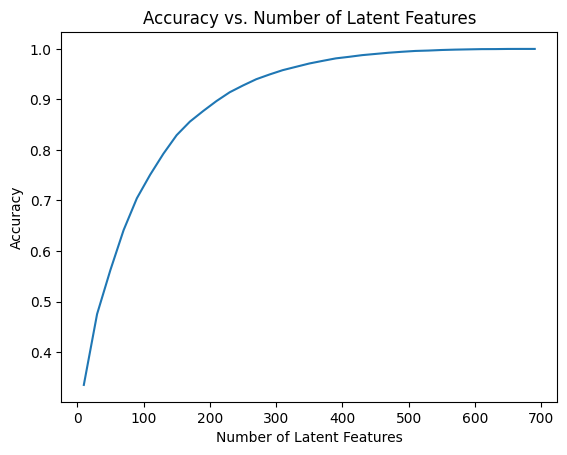

In [251]:
num_latent_feature1 = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feature1:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feature1, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [252]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''

    # Your code here

    # user-item matrix of the training dataframe
    user_item_train = create_user_item_matrix(df_train)

    # user-item matrix of the testing dataframe
    user_item_test = create_user_item_matrix(df_test)

    test_idx = list(user_item_train.index)

    test_arts = list(user_item_train.columns)

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

user_item_train.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
user_item_train.index

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
      dtype='int64', name='user_id', length=4487)

In [254]:
print(f'{user_item_train.shape} {user_item_test.shape}')

(4487, 714) (682, 574)


`setdiff1d` is a function in the NumPy library for Python that finds the difference between two sets or arrays, returning the unique elements present in the first set but not in the second set. It is useful when you want to identify the distinct elements that exist in one dataset but not in another.

In the context of a recommender system or any data analysis task, `setdiff1d` can be used to:

1. Compare two datasets and identify unique items, users, or features present in one but not the other.
2. Check for data inconsistencies or missing data when combining or comparing datasets.
3. Evaluate a model's performance by comparing its predictions against actual data, focusing on differences.

By using `setdiff1d`, you can effectively understand the differences between two sets of data and make informed decisions about how to handle, process, or analyze the data.

In [255]:
# setdiff1d()
diff_index = np.setdiff1d(user_item_test.index, user_item_train.index)
diff_column = np.setdiff1d(user_item_test.columns, user_item_train.columns)
len_diff_index = len(diff_index)
len_diff_column = len(diff_column)

# print(f'{diff_index} {diff_column}')
print(f'{len_diff_index} {len_diff_column}')

662 0


In [256]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [257]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [258]:
# u_train, s_train, vt_train are TABLES
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [259]:
# Use these cells to see how well you can use the training 
# 'decomposition' to predict on test 


# Subset of rows in the user_item_test dataset that you can predict

#  Rows that match the test set
test_idx = user_item_test.index
row_idx = user_item_train.index.isin(test_idx) # >> array([False, False, False, ..., False, False,  True])
u_test = u_train[row_idx, : ] # : >> all columns, a 'slicing operation'

In [260]:
# Columns that match the test set
test_col = user_item_test.columns
col_idx = user_item_train.columns.isin(test_col)
vt_test = vt_train[ : , col_idx] # : >> all rows, a 'slicing operation'
vt_test

array([[-2.17234322e-03, -2.50211538e-02, -2.47568584e-03, ...,
        -1.19178349e-03, -1.75764013e-03, -4.04943583e-03],
       [ 2.07052261e-03, -2.21578691e-02,  1.47527709e-03, ...,
         2.10270582e-03,  8.19235025e-03,  1.53390757e-02],
       [-1.12698320e-03, -1.75169207e-03, -4.36025174e-03, ...,
        -5.90100152e-03, -5.73042987e-03, -1.64098364e-02],
       ...,
       [ 0.00000000e+00, -1.93292786e-17, -9.52484092e-17, ...,
         8.83064883e-18, -1.09636349e-17,  2.04264792e-16],
       [ 0.00000000e+00, -5.24500766e-18,  1.09409592e-16, ...,
         9.32516218e-17,  6.09978376e-17,  8.45964197e-17],
       [ 0.00000000e+00, -3.52424522e-17,  5.96160846e-17, ...,
         1.91440210e-16,  1.60740675e-16,  1.43522899e-16]])

In [261]:
# Test data
train_idx = user_item_train.index
row_idx_2 = user_item_test.index.isin(train_idx) # >> array([False, False, False, ..., False, False,  True])
sub_user_item_test = user_item_test.loc[row_idx_2] # >> 20 rows × 574 columns
sub_user_item_test.head()

wat1= np.sum(np.sum(sub_user_item_test))
wat1

218.0

In [262]:
latent_feature1 = np.arange(10, 700+10, 20) # start, stop, step (latent 'features/ special things')

all_errs, train_errs, test_errs = [], [], [] # list of errors


'''
    np.diag(s_train[:k]) creates a diagonal matrix using the first k singular values from s_train. 
    This is done to construct the Σ (Sigma) matrix with only the top k singular values, 
    which is then used to approximate the original user-item interaction matrix with a reduced number of latent features.
'''

for k in latent_feature1:
    # print(f'k = {k}')

    # restructure with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[0:k]), u_train[ : , 0:k], vt_train[0:k, : ]
    
    u_test_lat, vt_test_lat = u_test[ : , 0:k], vt_test[0:k, : ]

    # Taking the dot product in this code snippet is a part of the process to reconstruct 
    # the original user-item interaction matrix using the reduced SVD components with k latent features. 
    asdf1 = np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat)
    user_item_train_predict = np.around(asdf1)
     
    asdf2 = np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat)
    user_item_test_predict = np.around(asdf2)

    # Calculate the total number of predictions made by adding up the predictions for the user-item pairs in the test set and the sub-test set
    total_predictions = np.sum(user_item_test_predict) + np.sum(np.sum(sub_user_item_test))

    # Calculate the average prediction by dividing the total number of predictions by the total number of user-item pairs in the test set and the sub-test set
    average_prediction = total_predictions / (sub_user_item_test.shape[0] * sub_user_item_test.shape[1])
    
    # Calculate the error by subtracting the average prediction from 1 (since we want to maximize the prediction accuracy)
    error = 1 - average_prediction
    
    # Add the error to the list of all errors for later analysis
    all_errs.append(error)


    from sklearn.metrics import accuracy_score

    # Compute the prediction accuracy for the training set
    # by flattening the actual and predicted ratings arrays
    # and using the accuracy_score function from scikit-learn
    train_errs.append(accuracy_score(user_item_train.values.flatten(), user_item_train_predict.flatten()))

    # Compute the prediction accuracy for the test set by
    # flattening the actual and predicted ratings arrays
    # for a subset of user-item pairs, and using the accuracy_score function
    test_errs.append(accuracy_score(sub_user_item_test.values.flatten(), user_item_test_predict.flatten()))


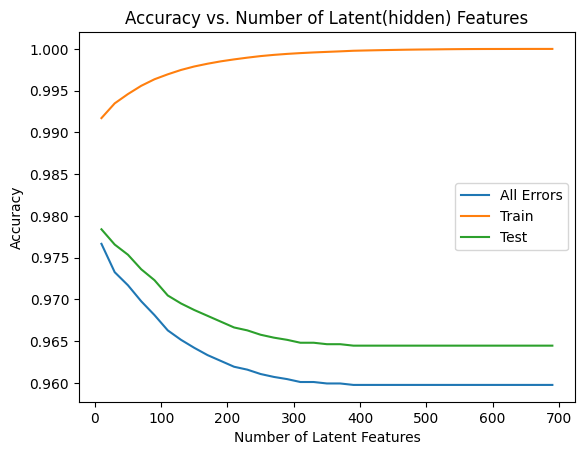

In [263]:
# Plot the prediction accuracy for the training and test sets
plt.figure()
plt.plot(latent_feature1, all_errs, label='All Errors')
plt.plot(latent_feature1, train_errs, label='Train')
plt.plot(latent_feature1, test_errs, label='Test')
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent(hidden) Features')
plt.legend()
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**


#### High accuracy but misleading results
- The model's overall accuracy is very high.
- This high accuracy is misleading because there is a class imbalance in the data. 
- Class imbalance means that one class (e.g., non-interactions, represented by zeros) is much more than the other 'class' 
    (e.g., interactions, represented by ones). 
- Thus, the 'model' can get high accuracy by mostly predicting the majority class, but not performing well on the 'smaller'  class.

#### Training accuracy vs. testing accuracy
- When the number of 'latent features' increases, the training accuracy approaches 100%, indicating that the model is     fitting the training data very well. 

- But the testing accuracy decreases as the number of latent features increases, which might be a sign of   'overfitting'.       
- Meaning the 'model' is fitting the training data too closely and fails to generalize well to the test data.


#### Potential solution - Cross Validation 
- 'cross Validation' a technique where the dataset is divided into multiple subsets (groups), and the model is trained and tested on different combinations of these subsets. 

- 'cross validation' can helps to determine the optimal number of latent features that provide the best balance between fitting the training data and generalizing to unseen data. 

- using Cross Validation, the model can be exposed to different subsets of the dataset, potentially improving its ability to generalize and avoiding overfitting.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [2]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])